In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import librosa as lr
from keras.utils import Sequence, to_categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from keras.layers import Convolution2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import GlobalMaxPool2D
from keras.layers import MaxPool2D
from keras.layers import concatenate
from keras.layers import Activation
from keras.layers import Input
from keras.layers import Dense
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                            ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.activations import relu, softmax
from keras import losses, models, optimizers
from keras import backend as K
from keras.models import Model
from keras.models import model_from_json
import pickle

Using TensorFlow backend.


In [4]:
import tensorflow as tf
import random as rn

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)


# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [5]:
fileList = []
#TODO: make this configurable
for root, dirs, files in os.walk("/Users/adityaasthana/cs196/training_data/Audio_Speech_Actors_01-24"):
    for file in files:
        if file.endswith(".wav"):
             fileList.append(os.path.join(root, file))

In [6]:
print(len(fileList))

1440


In [9]:
y_category = []
y_intensity = []
y_cat = []

for x in range(len(fileList)):
    fileName = fileList[x]
    #print(fileName)
    subStrings = fileName.split('/')
    wavFileName = subStrings[7]
    if '-' in wavFileName:
        fileSubstrings = wavFileName.split('-')
        emotion = fileSubstrings[2]
        print(emotion)
        if (emotion == '01'):
            y_category.append('neutral')
        elif (emotion == '02'):
            y_category.append('calm')
        elif (emotion == '03'):
            y_category.append('happy')
        elif (emotion == '04'):
            y_category.append('sad')
        elif (emotion == '05'):
            y_category.append('angry')
        elif (emotion == '06'):
            y_category.append('fearful')
        elif (emotion == '07'):
            y_category.append('disgust')
        else:
            y_category.append('surprised')
        y_cat.append(int(emotion) - 1)
        print(y_category[x])    
        print(y_cat[x])
    #y_intensity.append(fileSubstrings[3])
    #print(y_intensity[x])
    else:
        y_category.append('sad')
        y_cat.append(3)
        print(y_cat[x])
    

05
angry
4
06
fearful
5
06
fearful
5
05
angry
4
07
disgust
6
04
sad
3
04
sad
3
07
disgust
6
08
surprised
7
08
surprised
7
03
happy
2
03
happy
2
02
calm
1
01
neutral
0
02
calm
1
03
happy
2
03
happy
2
02
calm
1
02
calm
1
01
neutral
0
06
fearful
5
05
angry
4
05
angry
4
06
fearful
5
04
sad
3
07
disgust
6
07
disgust
6
04
sad
3
08
surprised
7
08
surprised
7
02
calm
1
01
neutral
0
02
calm
1
03
happy
2
03
happy
2
07
disgust
6
04
sad
3
04
sad
3
07
disgust
6
05
angry
4
06
fearful
5
06
fearful
5
05
angry
4
08
surprised
7
08
surprised
7
04
sad
3
07
disgust
6
07
disgust
6
04
sad
3
06
fearful
5
05
angry
4
05
angry
4
06
fearful
5
08
surprised
7
08
surprised
7
01
neutral
0
02
calm
1
02
calm
1
03
happy
2
03
happy
2
01
neutral
0
02
calm
1
02
calm
1
03
happy
2
03
happy
2
04
sad
3
07
disgust
6
07
disgust
6
04
sad
3
06
fearful
5
05
angry
4
05
angry
4
06
fearful
5
08
surprised
7
08
surprised
7
07
disgust
6
04
sad
3
04
sad
3
07
disgust
6
05
angry
4
06
fearful
5
06
fearful
5
05
angry
4
08
surprised
7
08
surpr

1
03
happy
2
03
happy
2
01
neutral
0
02
calm
1
02
calm
1
03
happy
2
03
happy
2
04
sad
3
07
disgust
6
07
disgust
6
04
sad
3
06
fearful
5
05
angry
4
05
angry
4
06
fearful
5
08
surprised
7
08
surprised
7
03
happy
2
03
happy
2
02
calm
1
01
neutral
0
02
calm
1
05
angry
4
06
fearful
5
06
fearful
5
05
angry
4
07
disgust
6
04
sad
3
04
sad
3
07
disgust
6
08
surprised
7
08
surprised
7
06
fearful
5
05
angry
4
05
angry
4
06
fearful
5
04
sad
3
07
disgust
6
07
disgust
6
04
sad
3
08
surprised
7
08
surprised
7
03
happy
2
03
happy
2
02
calm
1
02
calm
1
01
neutral
0
03
happy
2
03
happy
2
02
calm
1
02
calm
1
01
neutral
0
06
fearful
5
05
angry
4
05
angry
4
06
fearful
5
04
sad
3
07
disgust
6
07
disgust
6
04
sad
3
08
surprised
7
08
surprised
7
05
angry
4
06
fearful
5
06
fearful
5
05
angry
4
07
disgust
6
04
sad
3
04
sad
3
07
disgust
6
08
surprised
7
08
surprised
7
03
happy
2
03
happy
2
02
calm
1
01
neutral
0
02
calm
1
04
sad
3
07
disgust
6
07
disgust
6
04
sad
3
06
fearful
5
05
angry
4
05
angry
4
06
fearful
5

In [10]:
class SetUp(object):
    def __init__(self,
                 sampling_rate=16000, audio_duration=2, n_classes=8,
                 use_mfcc=False, n_folds=10, learning_rate=0.0001, 
                 max_epochs=100, n_mfcc=20):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.use_mfcc = use_mfcc
        self.n_mfcc = n_mfcc
        self.n_folds = n_folds
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs

        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)

In [12]:
setup = SetUp(sampling_rate=44100, audio_duration=3, n_folds=10, 
                learning_rate=0.01, use_mfcc=True, n_mfcc=40)

In [13]:
print(setup.dim[0])
print(setup.dim[1])

40
259


In [14]:
def prepare_data(fileList, config):
    X = np.empty(shape=(len(fileList), config.dim[0], config.dim[1], 1))
    input_length = config.audio_length
    for i, fname in enumerate(fileList):
        #print(fname)
        file_path = fname
        data, _ = lr.core.load(file_path, sr=config.sampling_rate, res_type="kaiser_fast", offset=0.5)

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

        data = lr.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
        data = np.expand_dims(data, axis=-1)
        X[i,] = data
    return X

In [15]:
X = prepare_data(fileList, setup)
print(X.shape)

(1440, 40, 259, 1)


In [22]:
y = to_categorical(y_cat, num_classes=setup.n_classes)

In [23]:
print(y.shape)

(1440, 8)


In [24]:
print(type(X))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [25]:
from sklearn.model_selection import train_test_split
#xDataTrain, xDataTest, y_train, y_test = train_test_split(Xdata, y, test_size = 0.2, random_state = 43)
X_train_1, X_test, y_train_1, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

yTrain = y_train_1

In [26]:
#print(xDataTrain.shape)
print(X_train_1.shape)
print(y_train_1.shape)

(1152, 40, 259, 1)
(1152, 8)


In [27]:
print(X_test.shape)
print(y_test.shape)

(288, 40, 259, 1)
(288, 8)


In [28]:
print(y_test)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [29]:
mean = np.mean(X_train_1, axis=0)
std = np.std(X_train_1, axis=0)

# write to Pickle
pickle.dump( mean, open( "mean.pkl", "wb" ) )
pickle.dump( std, open( "std.pkl", "wb" ) )

X_train_1 = (X_train_1 - mean)/std
X_test = (X_test - mean)/std

In [30]:
def get_2d_conv_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    print(model.summary())
    return model

In [31]:
LABELS = list(np.unique(np.array(y_category)))
print(LABELS)

['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [32]:
X_train, X_val, y_train, y_val = train_test_split(X_train_1, y_train_1, test_size = 0.2, random_state = 42)

In [35]:
PREDICTION_FOLDER = "predictions_2d_conv_single"
if not os.path.exists(PREDICTION_FOLDER):
    os.mkdir(PREDICTION_FOLDER)
if os.path.exists('logs/' + PREDICTION_FOLDER):
    shutil.rmtree('logs/' + PREDICTION_FOLDER)




checkpoint = ModelCheckpoint(filepath='weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_1', write_graph=True)
callbacks_list = [checkpoint, tb, reduce_lr]
print("#"*50)
model = get_2d_conv_model(setup)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=callbacks_list, 
                        batch_size=64, epochs=setup.max_epochs)

model.load_weights('weights.best.from_scratch.hdf5')
    
# Save train predictions
predictions_train = model.predict(X_train_1, batch_size=64, verbose=1)
np.save(PREDICTION_FOLDER + "/train_predictions.npy", predictions_train)

# Save test predictions
predictions = model.predict(X_test, batch_size=64, verbose=1)
np.save(PREDICTION_FOLDER + "/test_predictions.npy", predictions)

##################################################
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 40, 259, 1)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 259, 32)       1312      
_________________________________________________________________
batch_normalization_6 (Batch (None, 40, 259, 32)       128       
_________________________________________________________________
activation_6 (Activation)    (None, 40, 259, 32)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 129, 32)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 20, 129, 32)       40992     
_________________________________________________________________
batch_normalization_7 (Ba

921/921 [==============================] - 84s 91ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 1.1898 - val_acc: 0.7186

Epoch 00024: val_loss improved from 1.19380 to 1.18984, saving model to weights.best.from_scratch.hdf5
Epoch 25/100
921/921 [==============================] - 84s 91ms/step - loss: 0.0021 - acc: 1.0000 - val_loss: 1.1765 - val_acc: 0.7186

Epoch 00025: val_loss improved from 1.18984 to 1.17647, saving model to weights.best.from_scratch.hdf5
Epoch 26/100
921/921 [==============================] - 84s 91ms/step - loss: 0.0033 - acc: 1.0000 - val_loss: 1.1656 - val_acc: 0.7273

Epoch 00026: val_loss improved from 1.17647 to 1.16562, saving model to weights.best.from_scratch.hdf5
Epoch 27/100
921/921 [==============================] - 84s 91ms/step - loss: 0.0021 - acc: 1.0000 - val_loss: 1.1533 - val_acc: 0.7186

Epoch 00027: val_loss improved from 1.16562 to 1.15331, saving model to weights.best.from_scratch.hdf5
Epoch 28/100
921/921 [==============================]

921/921 [==============================] - 84s 91ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 1.1181 - val_acc: 0.7316

Epoch 00062: val_loss did not improve from 1.10833
Epoch 63/100
921/921 [==============================] - 84s 91ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 1.1182 - val_acc: 0.7316

Epoch 00063: val_loss did not improve from 1.10833
Epoch 64/100
921/921 [==============================] - 84s 91ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 1.1185 - val_acc: 0.7316

Epoch 00064: val_loss did not improve from 1.10833
Epoch 65/100
921/921 [==============================] - 84s 91ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 1.1186 - val_acc: 0.7316

Epoch 00065: val_loss did not improve from 1.10833
Epoch 66/100
921/921 [==============================] - 84s 91ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 1.1184 - val_acc: 0.7316

Epoch 00066: val_loss did not improve from 1.10833

Epoch 00066: ReduceLROnPlateau reducing learning rate to 9.9999988378840

In [36]:
#TODO: make this configurable
predicted_test_data = np.load('/Users/adityaasthana/cs196/predictions_2d_conv_single/test_predictions.npy')
predicted_labels_test = np.argmax(predicted_test_data, axis=-1)  
#print(data[0])
print(predicted_labels_test)
correct_test_label = np.argmax(y_test, axis=-1)  
print(correct_test_label)
print(len(correct_test_label))

print("#"*50)

#TODO: make this configurable
predicted_train_data = np.load('/Users/adityaasthana/cs196/predictions_2d_conv_single/train_predictions.npy')
predicted_labels_train = np.argmax(predicted_train_data, axis=-1)
print(predicted_labels_train )
correct_train_label = np.argmax(y_train_1, axis=-1)  
print(correct_train_label)
print(len(correct_train_label))

[5 6 7 3 7 2 1 3 3 4 6 3 3 0 3 2 1 6 2 4 4 6 7 4 5 1 7 3 4 0 7 3 0 6 4 4 5
 4 5 7 4 2 1 5 5 6 6 7 7 7 2 1 7 7 1 1 2 2 1 1 5 5 5 1 6 4 3 7 3 6 1 4 5 7
 1 6 3 1 5 1 7 6 2 2 6 3 4 4 2 5 2 7 3 2 6 3 6 4 1 5 4 1 5 2 6 1 0 6 5 1 7
 1 1 4 2 0 1 5 5 4 6 5 2 7 4 4 1 7 7 7 1 1 5 3 1 2 4 6 5 5 1 5 5 3 1 0 5 2
 1 1 5 5 7 1 1 7 7 7 4 2 4 1 7 7 5 2 2 6 3 6 4 6 7 2 6 0 0 0 0 6 2 1 6 6 7
 0 3 4 1 0 7 7 6 4 3 5 3 4 0 6 7 4 0 1 0 0 5 2 7 6 6 7 6 3 2 5 3 3 1 2 1 6
 0 5 5 1 4 2 4 1 7 6 7 6 6 2 2 2 5 1 4 6 3 0 7 0 7 5 4 3 0 2 4 5 7 5 2 7 4
 6 7 2 5 2 5 2 4 7 6 6 1 1 4 4 7 2 7 3 1 1 2 2 3 7 4 7 7 7]
[2 6 7 3 7 6 1 3 2 4 6 3 3 0 3 2 3 6 6 4 4 6 7 4 6 1 7 5 4 0 7 3 0 6 4 4 5
 2 0 7 4 2 1 7 5 6 6 7 7 7 2 1 1 2 1 3 7 2 1 1 5 5 2 1 6 2 3 7 0 6 1 4 6 3
 1 6 3 1 5 4 7 6 2 7 4 3 5 4 2 5 2 6 5 2 6 3 6 4 1 5 2 1 4 3 6 1 0 6 5 1 7
 1 1 4 2 0 0 5 5 4 6 5 2 7 6 4 1 7 2 2 1 1 5 3 1 2 4 6 5 5 1 5 5 1 1 0 5 2
 1 1 2 2 2 3 1 2 7 7 7 4 4 1 4 3 2 2 2 6 3 6 4 6 7 3 3 0 1 1 0 6 5 1 3 6 7
 0 3 4 1 2 7 7 5 4 3 5 6 5 0 6 7 5 0 1 3

In [37]:
#Determine training efficiency
train_accuracy_count = 0.0
train_in_accuracy_count = 0.0
for i in range(len(predicted_labels_train)):
    if correct_train_label[i] == predicted_labels_train[i]:
        train_accuracy_count +=1
    else:
        train_in_accuracy_count +=1
print("Accuracy % :", ((train_accuracy_count/len(predicted_labels_train))*100))

Accuracy % : 94.70486111111111


In [39]:
#Determine testing efficiency
test_accuracy_count = 0.0
test_in_accuracy_count = 0.0
for i in range(len(predicted_labels_test)):
    if correct_test_label[i] == predicted_labels_test[i]:
        test_accuracy_count +=1
    else:
        test_in_accuracy_count +=1
print("Accuracy % :", ((test_accuracy_count/len(predicted_labels_test))*100))

Accuracy % : 69.44444444444444


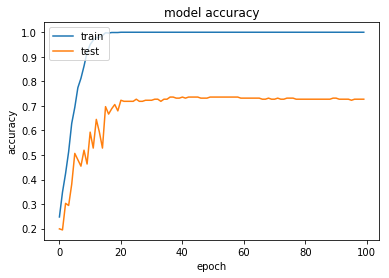

In [40]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
#Save model
model_json = model.to_json()
with open('/Users/adityaasthana/cs196/model_final.json', 'w') as json_file:  #TODO: make this configurable
    json_file.write(model_json)

In [45]:
#Save Model and Architecture
model.save("model_group26.h5")   #TODO: make this configurable